In [ ]:
import pandas as pd
import os
import glob
import openpyxl

In [3]:
# Here's the updated function.
# If you run this function in your local environment, it should format the unique values from the Excel column and copy the result to your clipboard.

# Process the provided Excel file and copy the result to clipboard
import pandas as pd
def format_and_copy_to_clipboard_v3(input_excel_path):
    # Load the Excel file
    df = pd.read_excel(input_excel_path)

    # Drop duplicates and NaN values, then sort
    unique_values = sorted(df[df.columns[0]].dropna().drop_duplicates().tolist())

    # Convert the unique values to a single comma-separated string
    formatted_string = ", ".join(map(str, unique_values))

    # Copy to clipboard
    pd.Series([formatted_string]).to_clipboard(index=False, header=False)

input_path = r"C:\Users\Fei\Desktop\ID.xlsx"
format_and_copy_to_clipboard_v3(input_path)

In [137]:

import arcpy
import numpy as np
import pandas as pd
import tqdm as tqdm
import datetime, time


def U_Turn_Direction_Judgement(lane_from):
    if 'EB' in lane_from:
        u_turn_direction = 'EB_to_WB'
    elif 'WB' in lane_from:
        u_turn_direction = 'WB_to_EB'
    elif 'SB' in lane_from:
        u_turn_direction = 'SB_to_NB'
    elif 'NB' in lane_from:
        u_turn_direction = 'NB_to_SB'
    else:
        u_turn_direction = 'Unknown'
    return u_turn_direction



def extract_vehicle_data(point_layer, polygon_zone1, polygon_zone2,site):
    # 使用多边形区域选择点
    arcpy.SelectLayerByLocation_management(point_layer, "INTERSECT", polygon_zone1)
    selected_zone1 = [row[0] for row in arcpy.da.SearchCursor(point_layer, "ObjectID")]

    arcpy.SelectLayerByLocation_management(point_layer, "INTERSECT", polygon_zone2)
    selected_zone2 = [row[0] for row in arcpy.da.SearchCursor(point_layer, "ObjectID")]

    # 找到同时在两个区域中的点的ObjectID
    common_vehicles = set(selected_zone1).intersection(selected_zone2)

    # 创建一个空的DataFrame来存储结果
    columns = ['ObjectID', 'Min_Timestamp', 'Class', 'Date', 'Rounded_Time', 'Direction','site']
    df = pd.DataFrame(columns=columns)

    direction = U_Turn_Direction_Judgement(polygon_zone1)

    # 提取相关数据
    for vehicle_id in common_vehicles:
        query = "ObjectID = {}".format(vehicle_id)
        timestamps = [datetime.strptime(row[0], "%Y-%m-%d %H:%M:%S") for row in arcpy.da.SearchCursor(point_layer, "Timestamp", query)]
        classes = [row[0] for row in arcpy.da.SearchCursor(point_layer, "Class", query)]

        min_timestamp = min(timestamps)
        vehicle_class = classes[0]  # 假设每个车辆的Class字段是相同的

        # 转换时间戳并向下取整
        min_date = min_timestamp.date()
        min_time = time(min_timestamp.hour, 15 * (min_timestamp.minute // 15))



        df = df.append({
            'ObjectID': vehicle_id,
            'Min_Timestamp': min_timestamp,
            'Class': vehicle_class,
            'Date': min_date,
            'Rounded_Time': min_time,
            'Direction': direction,
            'Site': site
        }, ignore_index=True)

    return df


In [ ]:
def Project_Map(map_unprojected):
    print('Projection start...')
    b = []
    for a in map_unprojected:

        if 'Project' not in a:
            if '{}_Project'.format(a) not in map_unprojected:
                arcpy.management.Project(a, '{}_Project'.format(a), arcpy.SpatialReference(26911))
                # 26911: Projection Coordinate System code for NAD 1983 UTM Zone 11N,best for Reno area.
                b.append('{}_Project'.format(a))
                # print('Finish {}_Project'.format(a))
        else:
            b.append(a)
            # print('Finish {}'.format(a))
    b.sort()
    print('Projection finished, start analyzing.')
    return b

In [8]:
import arcpy
import datetime
import pandas as pd
from tqdm import tqdm





def U_Turn_Direction_Judgement(lane_from):
    if 'EB' in lane_from:
        u_turn_direction = 'EB_to_WB'
    elif 'WB' in lane_from:
        u_turn_direction = 'WB_to_EB'
    elif 'SB' in lane_from:
        u_turn_direction = 'SB_to_NB'
    elif 'NB' in lane_from:
        u_turn_direction = 'NB_to_SB'
    else:
        u_turn_direction = 'Unknown'
    return u_turn_direction



def extract_vehicle_data(point_layer, polygon_zone1, polygon_zone2, site):
    # 将整个地图的属性表读取到一个pandas DataFrame中
    field_names = [f.name for f in arcpy.ListFields(point_layer)]
    data = [row for row in arcpy.da.SearchCursor(point_layer, field_names)]
    df_all = pd.DataFrame(data, columns=field_names)

    # 使用多边形区域选择点
    arcpy.SelectLayerByLocation_management(point_layer, "INTERSECT", polygon_zone1)
    selected_zone1 = set(row[0] for row in arcpy.da.SearchCursor(point_layer, "ObjectID"))

    arcpy.SelectLayerByLocation_management(point_layer, "INTERSECT", polygon_zone2)
    selected_zone2 = set(row[0] for row in arcpy.da.SearchCursor(point_layer, "ObjectID"))

    # 找到同时在两个区域中的点的ObjectID
    common_vehicles = selected_zone1.intersection(selected_zone2)

    # 创建一个空的DataFrame来存储结果
    columns = ['ObjectID', 'Min_Timestamp', 'Class', 'Date', 'Rounded_Time', 'Direction', 'Site']
    df_result = pd.DataFrame(columns=columns)

    direction = U_Turn_Direction_Judgement(polygon_zone1)

    # 提取相关数据
    for vehicle_id in common_vehicles:
        vehicle_data = df_all[df_all['ObjectID'] == vehicle_id]

        min_timestamp = vehicle_data['Timestamp'].min()
        vehicle_class = vehicle_data['Class'].iloc[0]

        # 转换时间戳并向下取整
        min_timestamp = pd.to_datetime(min_timestamp)
        min_date = min_timestamp.date()
        min_time = min_timestamp.replace(minute=15 * (min_timestamp.minute // 15)).time()

        new_row = pd.DataFrame({
            'ObjectID': [vehicle_id],
            'Min_Timestamp': [min_timestamp],
            'Class': [vehicle_class],
            'Date': [min_date],
            'Rounded_Time': [min_time],
            'Direction': [direction],
            'site': [site]
        })

        df_result = pd.concat([df_result, new_row], ignore_index=True)

    return df_result


In [12]:
df_result

,ObjectID,Min_Timestamp,Class,Date,Rounded_Time,Direction,Site,site
0,1,2023-05-16 13:30:01.214365005,1,2023-05-16,13:30:01.214365,WB_to_EB,NaN,Mcleod
1,2,2023-05-16 13:30:01.214365005,1,2023-05-16,13:30:01.214365,WB_to_EB,NaN,Mcleod
2,3,2023-05-16 13:30:01.214365005,1,2023-05-16,13:30:01.214365,WB_to_EB,NaN,Mcleod
3,6,2023-05-16 13:30:01.214365005,1,2023-05-16,13:30:01.214365,WB_to_EB,NaN,Mcleod
4,7,2023-05-16 13:30:01.214365005,3,2023-05-16,13:30:01.214365,WB_to_EB,NaN,Mcleod
...,...,...,...,...,...,...,...,...
23287,16371,2023-05-16 14:25:56.090115070,1,2023-05-16,14:15:56.090115,NB_to_SB,NaN,Mcleod
23288,16372,2023-05-16 14:25:56.090115070,1,2023-05-16,14:15:56.090115,NB_to_SB,NaN,Mcleod
23289,16373,2023-05-16 14:25:56.290115118,1,2023-05-16,14:15:56.290115,NB_to_SB,NaN,Mcleod
23290,16376,2023-05-16 14:25:56.490115166,1,2023-05-16,14:15:56.490115,NB_to_SB,NaN,Mcleod


In [ ]:
import arcpy
import datetime
import pandas as pd
from tqdm import tqdm
import os

def U_Turn_Lane_To_Judgement(lane_from, lane_nb_leave, lane_sb_leave, lane_wb_leave, lane_eb_leave):
    if 'EB' in lane_from:
        return lane_wb_leave
    elif 'WB' in lane_from:
        return lane_eb_leave
    elif 'SB' in lane_from:
        return lane_nb_leave
    elif 'NB' in lane_from:
        return lane_sb_leave
    else:
        return 'Unknown'


def U_Turn_Direction_Judgement(lane_from):
    if 'EB' in lane_from:
        u_turn_direction = 'EB_to_WB'
    elif 'WB' in lane_from:
        u_turn_direction = 'WB_to_EB'
    elif 'SB' in lane_from:
        u_turn_direction = 'SB_to_NB'
    elif 'NB' in lane_from:
        u_turn_direction = 'NB_to_SB'
    else:
        u_turn_direction = 'Unknown'
    return u_turn_direction


def extract_vehicle_data(point_layer, polygon_zone1, polygon_zone2, site_name):
    # 允许覆盖输出
    arcpy.env.overwriteOutput = True

    # 选择与polygon_zone1相交的点
    arcpy.MakeFeatureLayer_management(point_layer, 'tempLayer1')
    arcpy.SelectLayerByLocation_management('tempLayer1', 'WITHIN', polygon_zone1)
    selected_zone1 = set(row[0] for row in arcpy.da.SearchCursor('tempLayer1', "ObjectID"))

    # 选择与polygon_zone2相交的点
    arcpy.MakeFeatureLayer_management(point_layer, 'tempLayer2')
    arcpy.SelectLayerByLocation_management('tempLayer2', 'WITHIN', polygon_zone2)
    selected_zone2 = set(row[0] for row in arcpy.da.SearchCursor('tempLayer2', "ObjectID"))

    # 找到同时在两个区域中的点的ObjectID
    common_vehicles = selected_zone1.intersection(selected_zone2)

    # 从整个地图的属性表中提取相关数据
    df_all = pd.DataFrame([row for row in arcpy.da.SearchCursor(point_layer, ["ObjectID", "Timestamp", "Class"])],
                           columns=["ObjectID", "Timestamp", "Class"])

    # 根据common_vehicles筛选数据
    df_common = df_all[df_all['ObjectID'].isin(common_vehicles)]

    # 获取每个ObjectID的最小Timestamp
    df_result = df_common.groupby('ObjectID').agg({
        'Timestamp': 'min',
        'Class': 'first'
    }).reset_index()

    # 添加其他列
    direction = U_Turn_Direction_Judgement(polygon_zone1)
    df_result['Direction'] = direction
    df_result['Site'] = site_name
    df_result['Date'] = pd.to_datetime(df_result['Timestamp']).dt.date
    df_result['Rounded_Time'] = pd.to_datetime(df_result['Timestamp']).dt.round('15min').dt.time

    return df_result

wildcard ='map2023*'
site_list = ['Pecos']

for site_name in tqdm(site_list):
    base_path = r'Z:\Flamingo_SMP\{}'.format(site_name)

    # 检查并创建Analysis文件夹
    analysis_path = os.path.join(base_path, 'Analysis')
    if not os.path.exists(analysis_path):
        os.mkdir(analysis_path)

    # 检查并创建U_Turn文件夹
    u_turn_path = os.path.join(analysis_path, 'U_Turn')
    if not os.path.exists(u_turn_path):
        os.mkdir(u_turn_path)
    shpFile_folder = r'C:\Users\Fei\Documents\ArcGIS\Projects\QC\{}'.format(site_name)
    path_folder =  u_turn_path
    path_gdb = r'Z:\Flamingo_SMP\{}\{}.gdb'.format(site_name, site_name)

    vehLane_EB = r'{}\U_Turn\VehZone_EB.shp'.format(shpFile_folder)
    vehLane_NB = r'{}\U_Turn\VehZone_NB.shp'.format(shpFile_folder)
    vehLane_WB = r'{}\U_Turn\VehZone_WB.shp'.format(shpFile_folder)
    vehLane_SB = r'{}\U_Turn\VehZone_SB.shp'.format(shpFile_folder)
    vehLane_EB_leave = r'{}\U_Turn\VehZone_EB_leave.shp'.format(shpFile_folder)
    vehLane_NB_leave = r'{}\U_Turn\VehZone_NB_leave.shp'.format(shpFile_folder)
    vehLane_WB_leave = r'{}\U_Turn\VehZone_WB_leave.shp'.format(shpFile_folder)
    vehLane_SB_leave = r'{}\U_Turn\VehZone_SB_leave.shp'.format(shpFile_folder)
    list_vehZone = [vehLane_EB,vehLane_WB,vehLane_NB,vehLane_SB]
    with arcpy.EnvManager(scratchWorkspace=path_gdb, workspace=path_gdb):
        dataset = arcpy.ListFeatureClasses(feature_type='Point', wild_card=wildcard)
        df_result = pd.DataFrame()
        # dataset_projected = Project_Map(dataset)
        for map_30min in tqdm(dataset):
            for each_direction in list_vehZone:

                df_to_append = extract_vehicle_data(map_30min, each_direction , U_Turn_Lane_To_Judgement(each_direction,vehLane_NB_leave,vehLane_SB_leave,vehLane_WB_leave,vehLane_EB_leave), site_name)
                df_result = pd.concat([df_result, df_to_append], ignore_index=True)
        df_result.to_csv('{}\\Results_YieldAnalysis'.format(path_folder) + '{}.csv'.format(site_name))

In [12]:
import pandas as pd

def count_labels(excel_path):
    # 读取 Excel 文件
    df = pd.read_excel(excel_path)

    # 计算 'Labeled Class' 列中每个值的数量
    label_counts = df['Labeled Class'].value_counts().sort_index()

    # 为每个类别创建一个描述字符串
    labels_description = {
        1: 'vehicle',
        2: 'pedestrian',
        3: 'bicyclist',
        4: 'e-scooter/e-skate boarder',
        5: 'wheelchair',
        6: 'motorcyclist',
        7: 'pedestrian group',
        8: 'pedestrian with a trolley/cart/baby',
        9: 'truck'
    }

    # 将数字标签转换为文本描述，并生成统计结果
    output = []
    total_labeled = 0
    for label, count in label_counts.items():
        label_desc = labels_description.get(int(label), labels_description.get(int(str(label)[0]), 'Unknown'))
        if int(label) == 7:  # 特殊处理行人组
            group_size = int(str(label)[2]) if '.' in str(label) else 1
            label_desc += f" of {group_size}" if group_size else ""
            count *= group_size  # 将组计数乘以组大小
        output.append(f"{count} labeled as {label_desc}")
        total_labeled += count

    # 添加总计
    output.append(f"Total labeled: {total_labeled}")

    # 合并结果为单个字符串
    return '\n'.join(output)



# 调用函数
excel_path = r"C:\Users\Fei\Desktop\ForQC\Pecos\Pecos_All_labeled.xlsx"
result_text = count_labels(excel_path)
print(result_text)

13436 labeled as vehicle
3852 labeled as pedestrian
15224 labeled as bicyclist
8740 labeled as e-scooter/e-skate boarder
6208 labeled as motorcyclist
2096 labeled as pedestrian group of 2
2004 labeled as pedestrian with a trolley/cart/baby
Total labeled: 51560


In [11]:
import pandas as pd

# 读取Excel文件
all_data = pd.read_excel(r"C:\Users\Fei\Desktop\ForQC\Pecos\Pecos_All.xlsx", engine='openpyxl')
labeled_data = pd.read_excel(r"C:\Users\Fei\OneDrive - University of Nevada, Reno\Paper\Thesis_CS\Classification_Multimodal\Labeled.xlsx", engine='openpyxl')

# 确保日期是pandas的datetime类型
all_data['DateTime'] = pd.to_datetime(all_data['DateTime'])
labeled_data['DateTime'] = pd.to_datetime(labeled_data['DateTime'])

# 只保留日期和小时
all_data['DateHour'] = all_data['DateTime'].dt.strftime('%Y-%m-%d %H')
labeled_data['DateHour'] = labeled_data['DateTime'].dt.strftime('%Y-%m-%d %H')

# 将labeled_data中的信息合并到all_data中
merged_data = all_data.merge(labeled_data, left_on=['ObjectID', 'DateHour'], right_on=['NumericID', 'DateHour'], how='inner')

# 生成最终需要的列的列表
columns_needed = [col for col in all_data.columns if col != 'DateTime']  # 不包含原始的DateTime列
columns_needed.append('Labeled Class')  # 添加新的Labeled Class列

# 只保留需要的列
final_data = merged_data[columns_needed]


# 保存到新的Excel文件中
final_data.to_excel(r"C:\Users\Fei\Desktop\ForQC\Pecos\Pecos_All_labeled.xlsx", index=False, engine='openpyxl')


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.impute import SimpleImputer

# Load the processed data
file_path = r"C:\Users\Fei\Desktop\ForQC\Pecos\Pecos_Processed_Data_Final.xlsx"
data = pd.read_excel(file_path)

# Replace '<Null>' strings with np.nan
data = data.replace('<Null>', np.nan)

# Impute missing values for numerical columns
numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()
imputer = SimpleImputer(strategy='median')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Ensure the 'Labeled Class' column is of type 'category'
data['Labeled Class'] = data['Labeled Class'].astype('category')

# Exclude non-numeric columns for modeling
# Add your actual non-numeric column names here
non_numeric_columns = ['ObjectID', 'DateHour', 'NewObjectID']
X = data.drop(non_numeric_columns + ['Labeled Class'], axis=1)  # Drop non-numeric and the target column
y = data['Labeled Class'].cat.codes  # Convert categorical labels to integer codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(class_report)

Accuracy: 0.9998020389983173
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2682
           1       1.00      1.00      1.00       734
           2       1.00      1.00      1.00      3080
           3       1.00      1.00      1.00      1702
           4       1.00      1.00      1.00      1275
           5       1.00      1.00      1.00       223
           6       1.00      1.00      1.00       407

    accuracy                           1.00     10103
   macro avg       1.00      1.00      1.00     10103
weighted avg       1.00      1.00      1.00     10103



In [21]:
from sklearn.model_selection import cross_val_score

# Using the same RandomForestClassifier as before
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)

# Print the average score across all folds
print(f"Average cross-validation score: {cv_scores.mean()}")


Average cross-validation score: 0.7693235853641565


In [22]:
from sklearn.model_selection import GridSearchCV

# 设置参数网格
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # 树的数量
    'max_depth': [None, 10, 20, 30],      # 树的最大深度
    'min_samples_split': [2, 5, 10],      # 分裂内部节点所需的最小样本数
    'min_samples_leaf': [1, 2, 4]         # 在叶子节点处需要的最小样本数
}

# 初始化随机森林模型
rf = RandomForestClassifier(random_state=42)

# 初始化网格搜索
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# 执行网格搜索
grid_search.fit(X, y)

# 查看最佳参数
print(grid_search.best_params_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

Accuracy: 0.9996040779966346
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2682
           1       1.00      1.00      1.00       734
           2       1.00      1.00      1.00      3080
           3       1.00      1.00      1.00      1702
           4       1.00      1.00      1.00      1275
           5       1.00      1.00      1.00       223
           6       1.00      1.00      1.00       407

    accuracy                           1.00     10103
   macro avg       1.00      1.00      1.00     10103
weighted avg       1.00      1.00      1.00     10103



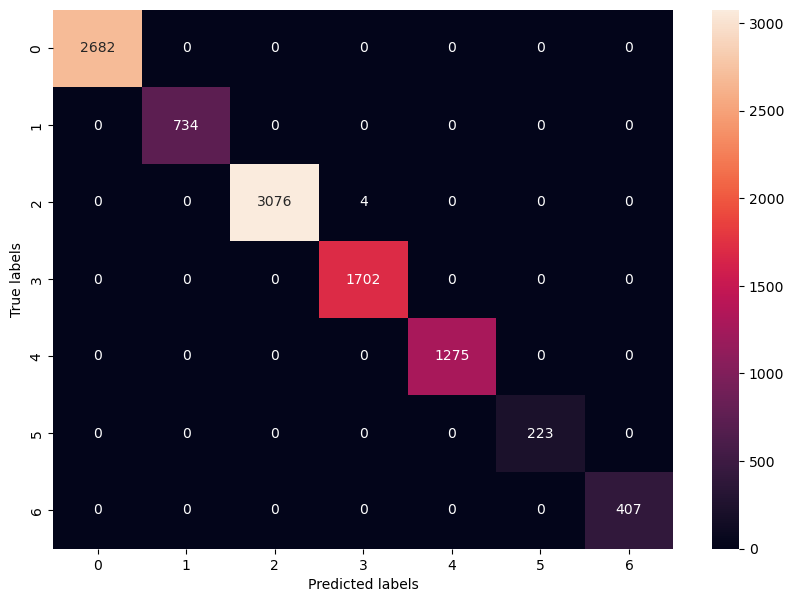

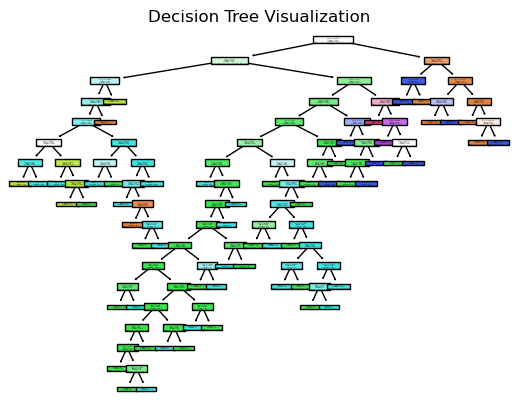

In [30]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# 假设 `X` 和 `y` 已经定义好了，并且数据已经被适当预处理

# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建决策树分类器实例
decision_tree = DecisionTreeClassifier(random_state=42)

# 训练模型
decision_tree.fit(X_train, y_train)

# 预测测试集
y_pred = decision_tree.predict(X_test)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)

# 生成分类报告
class_report = classification_report(y_test, y_pred)

# 生成混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 打印性能指标
print(f"Accuracy: {accuracy}")
print(class_report)
# 可视化混淆矩阵
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
plot_tree(decision_tree, filled=True)
plt.title('Decision Tree Visualization')
plt.show()

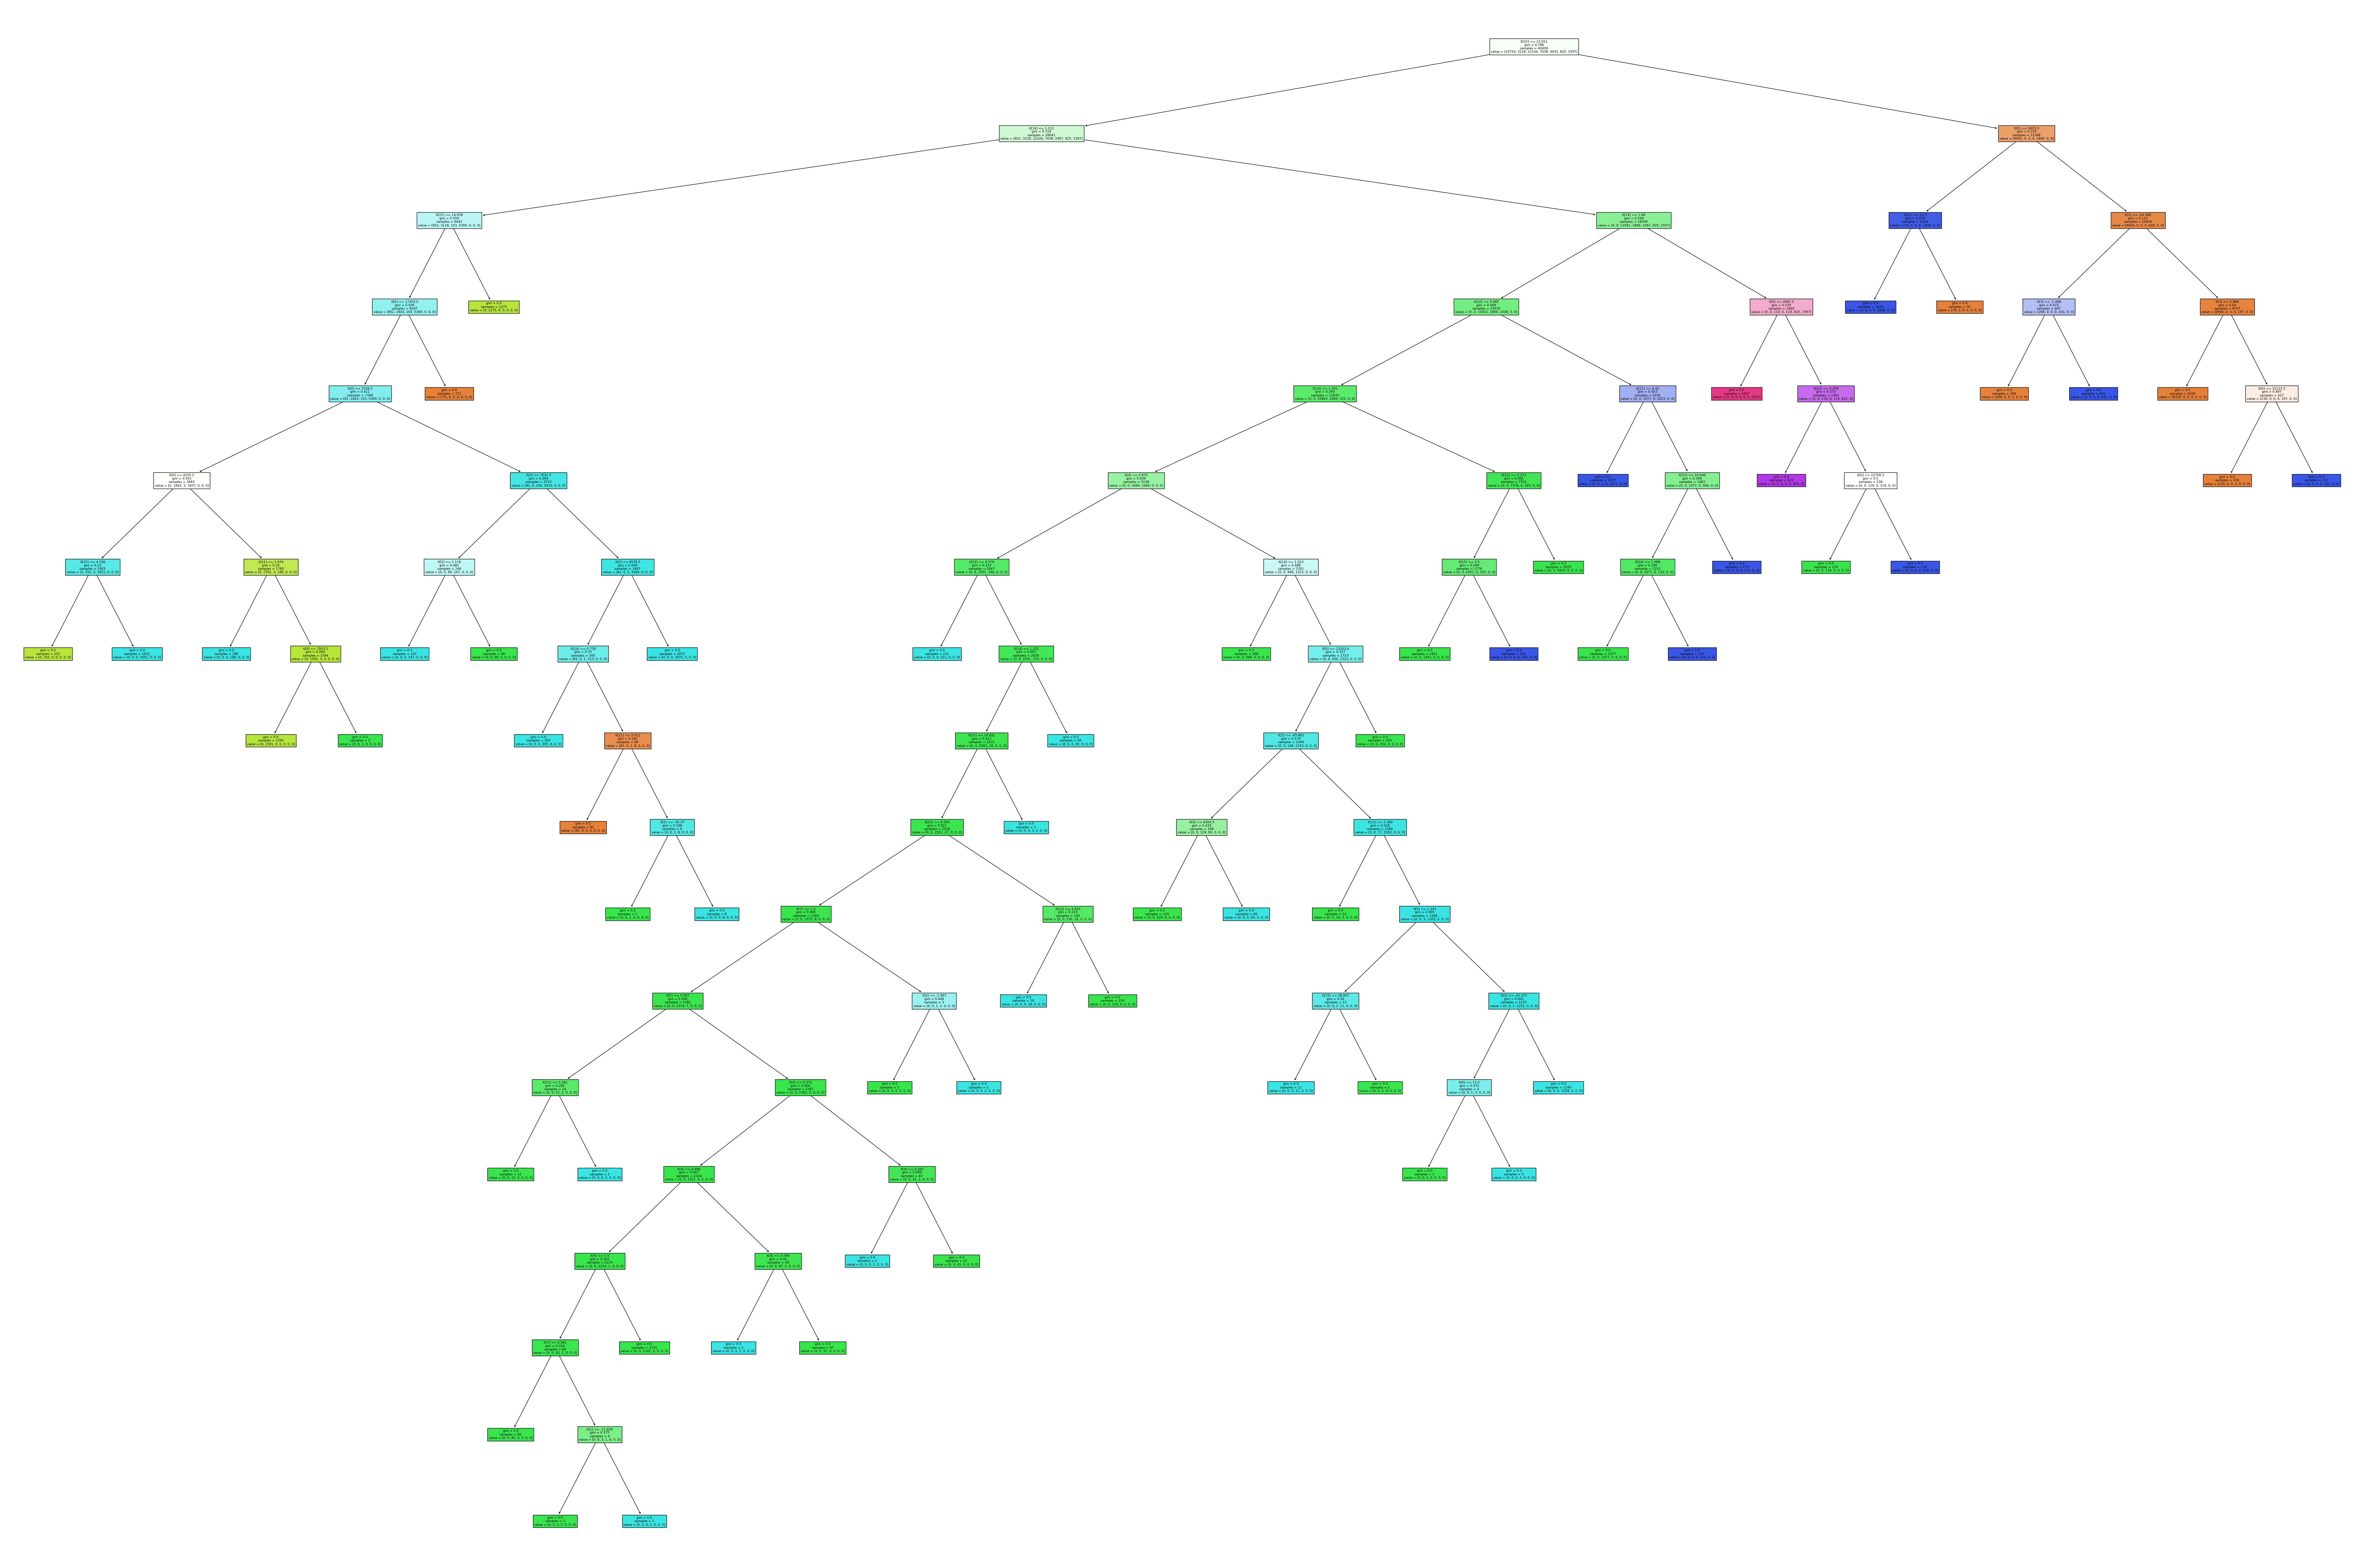

In [32]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Assuming clf is your trained decision tree classifier and iris.feature_names, iris.target_names are defined

# Increase the plot size (might need to adjust based on your screen resolution)
plt.figure(figsize=(90, 60))

# Plot the decision tree
plot_tree(decision_tree, filled=True)

# Save the plot to a file
plt.savefig('decision_tree_large.png', format='png', bbox_inches='tight')



In [1]:
import acrpy



ModuleNotFoundError: No module named 'acrpy'